In [1]:
#Attribution: this is a highly modified (improved?) version of the Pytorch tutorial here: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time
from io import open
import glob
import os
from io import BytesIO, TextIOWrapper
from zipfile import ZipFile
import requests
import matplotlib.ticker as ticker
import unicodedata
import string
import pandas as pd
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

all_letters = string.ascii_letters + " .,;'!@#$%^&*()_+1234567890-=/\<>{}" #added additional characters
n_letters = len(all_letters)

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    #line = str(line) #added str since some passwords are just numbers or nan
    tensor = torch.zeros(len(line), 1, n_letters) 
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [2]:
#Checking if passwords dont get passed through lineToTensor
df = pd.read_csv('data.csv', on_bad_lines = 'skip',na_filter=False)
for i in range(len(df.password)):
    lineToTensor(df.password[i])

In [3]:
class PasswordData(torch.utils.data.Dataset):
    def __init__(self, path):
        self.df = pd.read_csv(path, on_bad_lines ='skip',na_filter=False) #Theres a nan that gets read in
    def __getitem__(self, idx):
        assert 0 <= idx and idx < self.df.shape[0]
        pswrd = self.df['password'][idx]
        strength = self.df['strength'][idx]
        pswrd_tensor = lineToTensor(pswrd)
        strength_tensor = torch.tensor([strength], dtype=torch.long)
        return pswrd_tensor, strength_tensor, pswrd, strength
        
    def __len__(self):
        return self.df.shape[0]

In [4]:
passworddata = PasswordData("data.csv")
train_size =.8
test_size = .2
torch.manual_seed(0)
train_size = round(.8*len(passworddata))
training_data, testing_data = torch.utils.data.random_split(passworddata, [train_size, len(passworddata)-train_size])


In [5]:
batch_size = 64 #note that the batch size must be 1 here because the tensors 
#cannot be collated (i.e. concatenated along a single axis)
# Create data loaders.
def collate_fn(data):
    """
       data: is a list of tuples with (example, label, length)
             where 'example' is a tensor of arbitrary shape
             and label/length are scalars
    """
    return ([datum[i] for datum in data] for i in range(len(data[0])))

train_dataloader = DataLoader(training_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [6]:
# use cpu or gpu device if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = torch.relu(self.i2h(combined))
        output = self.h2o(hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size, device=device)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, 3).to(device) #0,1,2 for password strength

Using cpu device


In [7]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader)
    for ind, (X_list, y_list, _, _) in enumerate(dataloader): #iterate over the dataloader
        loss = 0.0
        batch_size = len(X_list)
        for batch_ind in range(batch_size): #iterate over the batch
            X, y = X_list[batch_ind].to(device), y_list[batch_ind].to(device)
            hidden = model.initHidden()
            for i in range(X.size()[0]): #iterate over the letters in the name
                output, hidden = model(X[i], hidden)
                
            loss += loss_fn(output, y)
    
        loss /= batch_size
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ind % 100 == 0:
            print(f"loss: {loss.item():>7f}  [{ind:>5d}/{size:>5d}]")

In [8]:
def test(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0.0, 0.0
    with torch.no_grad():
        for X_list, y_list, _, _ in dataloader:
            batch_size = len(X_list)
            loss = 0.0
            for batch_ind in range(batch_size):
                X, y = X_list[batch_ind].to(device), y_list[batch_ind].to(device)
                hidden = model.initHidden()

                for i in range(X.size()[0]):
                    output, hidden = model(X[i], hidden)
    
                test_loss += loss_fn(output, y).item()
                correct += (output.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= len(dataloader.dataset)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
learning_rate = 0.004 # If you set this too high, it might explode. If too low, it might not learn
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rnn.parameters(), learning_rate) #Using this optimizer because SGD was giving me 100% accuracy in just a few batches

#learning_rate = .005
#rnn = RNN(n_letters, n_hidden, 3).to(device)

#RMSprop is alternative to SGD that is often recommended for RNNs #This caused overfitting
#optimizer = torch.optim.RMSprop(rnn.parameters(), learning_rate)

torch.manual_seed(0)
epochs = 10
for t in range(epochs):
    start = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, rnn, criterion, optimizer)
    test(test_dataloader, rnn, criterion)
    print(f'Epoch ran in {time.time() - start :.2f} seconds')
    torch.save(rnn.state_dict(), f"rnn{t}.pt")
print("Done!")


Epoch 1
-------------------------------
loss: 1.092560  [    0/ 8371]
loss: 0.969427  [  100/ 8371]
loss: 0.886634  [  200/ 8371]
loss: 0.787420  [  300/ 8371]
loss: 0.874267  [  400/ 8371]
loss: 0.730038  [  500/ 8371]
loss: 0.684770  [  600/ 8371]
loss: 0.782009  [  700/ 8371]
loss: 0.832208  [  800/ 8371]
loss: 0.676518  [  900/ 8371]
loss: 0.810301  [ 1000/ 8371]
loss: 0.752651  [ 1100/ 8371]
loss: 0.799870  [ 1200/ 8371]
loss: 0.647170  [ 1300/ 8371]
loss: 0.781608  [ 1400/ 8371]
loss: 0.755116  [ 1500/ 8371]
loss: 0.730730  [ 1600/ 8371]
loss: 0.887379  [ 1700/ 8371]
loss: 0.818258  [ 1800/ 8371]
loss: 0.864792  [ 1900/ 8371]
loss: 0.635539  [ 2000/ 8371]
loss: 0.640721  [ 2100/ 8371]
loss: 0.806593  [ 2200/ 8371]
loss: 0.697405  [ 2300/ 8371]
loss: 0.770345  [ 2400/ 8371]
loss: 0.703306  [ 2500/ 8371]
loss: 0.742807  [ 2600/ 8371]
loss: 0.716578  [ 2700/ 8371]
loss: 0.610231  [ 2800/ 8371]
loss: 0.586180  [ 2900/ 8371]
loss: 0.572462  [ 3000/ 8371]
loss: 0.716620  [ 3100/ 8371]


loss: 0.000282  [  800/ 8371]
loss: 0.000107  [  900/ 8371]
loss: 0.000138  [ 1000/ 8371]
loss: 0.001239  [ 1100/ 8371]
loss: 0.000144  [ 1200/ 8371]
loss: 0.000183  [ 1300/ 8371]
loss: 0.000166  [ 1400/ 8371]
loss: 0.000131  [ 1500/ 8371]
loss: 0.000060  [ 1600/ 8371]
loss: 0.000214  [ 1700/ 8371]
loss: 0.000150  [ 1800/ 8371]
loss: 0.000104  [ 1900/ 8371]
loss: 0.000161  [ 2000/ 8371]
loss: 0.000206  [ 2100/ 8371]
loss: 0.000115  [ 2200/ 8371]
loss: 0.000134  [ 2300/ 8371]
loss: 0.000208  [ 2400/ 8371]
loss: 0.000053  [ 2500/ 8371]
loss: 0.000127  [ 2600/ 8371]
loss: 0.000114  [ 2700/ 8371]
loss: 0.000198  [ 2800/ 8371]
loss: 0.000118  [ 2900/ 8371]
loss: 0.000075  [ 3000/ 8371]
loss: 0.000290  [ 3100/ 8371]
loss: 0.000060  [ 3200/ 8371]
loss: 0.000126  [ 3300/ 8371]
loss: 0.000047  [ 3400/ 8371]
loss: 0.000128  [ 3500/ 8371]
loss: 0.000115  [ 3600/ 8371]
loss: 0.000356  [ 3700/ 8371]
loss: 0.000101  [ 3800/ 8371]
loss: 0.001988  [ 3900/ 8371]
loss: 0.000092  [ 4000/ 8371]
loss: 0.00

loss: 0.000023  [ 1700/ 8371]
loss: 0.000033  [ 1800/ 8371]
loss: 0.000005  [ 1900/ 8371]
loss: 0.000083  [ 2000/ 8371]
loss: 0.000008  [ 2100/ 8371]
loss: 0.000012  [ 2200/ 8371]
loss: 0.000003  [ 2300/ 8371]
loss: 0.000021  [ 2400/ 8371]
loss: 0.000008  [ 2500/ 8371]
loss: 0.000005  [ 2600/ 8371]
loss: 0.000015  [ 2700/ 8371]
loss: 0.000203  [ 2800/ 8371]
loss: 0.000014  [ 2900/ 8371]
loss: 0.000030  [ 3000/ 8371]
loss: 0.000035  [ 3100/ 8371]
loss: 0.000019  [ 3200/ 8371]
loss: 0.000020  [ 3300/ 8371]
loss: 0.000010  [ 3400/ 8371]
loss: 0.000038  [ 3500/ 8371]
loss: 0.000002  [ 3600/ 8371]
loss: 0.000003  [ 3700/ 8371]
loss: 0.000008  [ 3800/ 8371]
loss: 0.000008  [ 3900/ 8371]
loss: 0.000093  [ 4000/ 8371]
loss: 0.000007  [ 4100/ 8371]
loss: 0.000005  [ 4200/ 8371]
loss: 0.000015  [ 4300/ 8371]
loss: 0.000060  [ 4400/ 8371]
loss: 0.000010  [ 4500/ 8371]
loss: 0.000018  [ 4600/ 8371]
loss: 0.000014  [ 4700/ 8371]
loss: 0.000011  [ 4800/ 8371]
loss: 0.000003  [ 4900/ 8371]
loss: 0.00

loss: 0.000009  [ 2600/ 8371]
loss: 0.000006  [ 2700/ 8371]
loss: 0.000007  [ 2800/ 8371]
loss: 0.000002  [ 2900/ 8371]
loss: 0.000005  [ 3000/ 8371]
loss: 0.000006  [ 3100/ 8371]
loss: 0.000002  [ 3200/ 8371]
loss: 0.000003  [ 3300/ 8371]
loss: 0.000004  [ 3400/ 8371]
loss: 0.000005  [ 3500/ 8371]
loss: 0.000008  [ 3600/ 8371]
loss: 0.000003  [ 3700/ 8371]
loss: 0.000054  [ 3800/ 8371]
loss: 0.000011  [ 3900/ 8371]
loss: 0.000017  [ 4000/ 8371]
loss: 0.000011  [ 4100/ 8371]
loss: 0.000013  [ 4200/ 8371]
loss: 0.000006  [ 4300/ 8371]
loss: 0.000008  [ 4400/ 8371]
loss: 0.000004  [ 4500/ 8371]
loss: 0.000007  [ 4600/ 8371]
loss: 0.000002  [ 4700/ 8371]
loss: 0.000003  [ 4800/ 8371]
loss: 0.000006  [ 4900/ 8371]
loss: 0.000007  [ 5000/ 8371]
loss: 0.000005  [ 5100/ 8371]
loss: 0.000003  [ 5200/ 8371]
loss: 0.000015  [ 5300/ 8371]
loss: 0.000004  [ 5400/ 8371]
loss: 0.000001  [ 5500/ 8371]
loss: 0.000213  [ 5600/ 8371]
loss: 0.000004  [ 5700/ 8371]
loss: 0.000007  [ 5800/ 8371]
loss: 0.00

In [14]:
rnn.load_state_dict(torch.load("rnn1.pt",map_location=torch.device('cpu'), weights_only=True))
test_predictions = []
test_labels = []
rnn.eval()
with torch.no_grad():
    for X_list, y_list, _, _ in test_dataloader:
        batch_size = len(X_list)
        loss = 0.0
        for batch_ind in range(batch_size):
            X, y = X_list[batch_ind].to(device), y_list[batch_ind]
            hidden = rnn.initHidden()

            for i in range(X.size()[0]):
                output, hidden = rnn(X[i], hidden)
        
            test_predictions += [output.argmax(1).item()]
            test_labels += [y.item()]

C:\Users\jnloz\AppData\Local\Temp\ipykernel_7356\203215188.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\jnloz\AppData\Local\Temp\ipykernel_7356\203215188.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


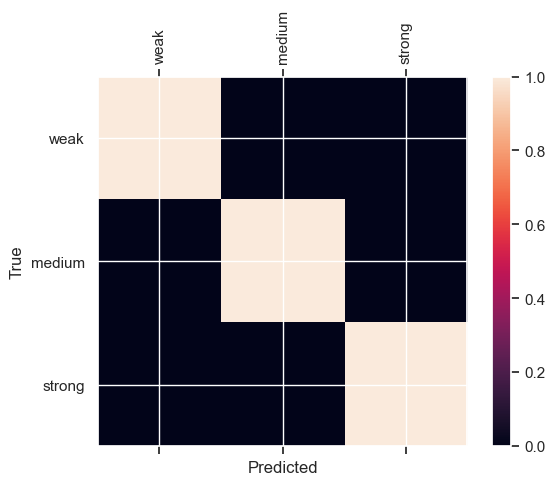

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_categories = ['weak','medium','strong']
c_mat = confusion_matrix(test_labels, test_predictions, normalize='true')
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(c_mat)
fig.colorbar(cax)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

plt.ylabel("True")
plt.xlabel("Predicted")

# sphinx_gallery_thumbnail_number = 2
plt.savefig("simple_rnn_confusion_mat.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

By the second epoch, the RNN model predicts with 100% accuracy. If I used RMSprop optimizer, then it would get to 100% accuracy before the first epoch even finished. This may be due to overfitting. 